# Task Solving with Code Generation, Execution and Debugging

AutoGen offers conversable LLM agents, which can be used to solve various tasks with human or automatic feedback, including tasks that require using tools via code.
Please find documentation about this feature [here](https://microsoft.github.io/autogen/docs/Use-Cases/agent_chat).

In this notebook, we demonstrate how to use `AssistantAgent` and `UserProxyAgent` to write code and execute the code. Here `AssistantAgent` is an LLM-based agent that can write Python code (in a Python coding block) for a user to execute for a given task. `UserProxyAgent` is an agent which serves as a proxy for the human user to execute the code written by `AssistantAgent`, or automatically execute the code. Depending on the setting of `human_input_mode` and `max_consecutive_auto_reply`, the `UserProxyAgent` either solicits feedback from the human user or returns auto-feedback based on the result of code execution (success or failure and corresponding outputs) to `AssistantAgent`. `AssistantAgent` will debug the code and suggest new code if the result contains error. The two agents keep communicating to each other until the task is done.

````{=mdx}
:::info Requirements
Install `pyautogen`:
```bash
pip install pyautogen
```

For more information, please refer to the [installation guide](/docs/installation/).
:::
````

In [1]:
from typing import Dict, Union

from IPython import get_ipython
from IPython.display import display, Image

import autogen

config_list = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    # filter_dict={
    #     "model": ["gpt-4", "gpt-4-0314", "gpt4", "gpt-4-32k", "gpt-4-32k-0314", "gpt-4-32k-v0314"],
    # },
)

````{=mdx}
:::tip
Learn more about configuring LLMs for agents [here](/docs/llm_configuration).
:::
````

## Example Task: Check Stock Price Change

In the example below, let's see how to use the agents in AutoGen to write a python script and execute the script. This process involves constructing a `AssistantAgent` to serve as the assistant, along with a `UserProxyAgent` that acts as a proxy for the human user. In this example demonstrated below, when constructing the `UserProxyAgent`,  we select the `human_input_mode` to "NEVER". This means that the `UserProxyAgent` will not solicit feedback from the human user. It stops replying when the limit defined by `max_consecutive_auto_reply` is reached, or when `is_termination_msg()` returns true for the received message.

In [2]:
# create an AssistantAgent named "assistant"
assistant = autogen.AssistantAgent(
    name="assistant",
    llm_config={
        "cache_seed": 41,  # seed for caching and reproducibility
        "config_list": config_list,  # a list of OpenAI API configurations
        "temperature": 0,  # temperature for sampling
    },  # configuration for autogen's enhanced inference API which is compatible with OpenAI API
)
# create a UserProxyAgent instance named "user_proxy"
user_proxy = autogen.UserProxyAgent(
    name="user_proxy",
    human_input_mode="NEVER",
    max_consecutive_auto_reply=10,
    is_termination_msg=lambda x: x.get("content", "").rstrip().endswith("TERMINATE"),
    code_execution_config={
        "work_dir": "coding",
        "use_docker": False,  # Please set use_docker=True if docker is available to run the generated code. Using docker is safer than running the generated code directly.
    },
)
# the assistant receives a message from the user_proxy, which contains the task description
chat_res = user_proxy.initiate_chat(
    assistant,
    message="""What date is today? Compare the year-to-date gain for META and TESLA.""",
    summary_method="reflection_with_llm",
)

user_proxy (to assistant):

What date is today? Compare the year-to-date gain for META and TESLA.

--------------------------------------------------------------------------------
self.reply_at_receive[sender]self.reply_at_receive[sender] True
recipitent sending assistant What date is today? Compare the year-to-date gain for META and TESLA. None
assistant (to user_proxy):

To get the current date, we can use Python's `datetime` module. After that, we will need to retrieve the year-to-date (YTD) gain for both META (Meta Platforms, Inc.) and TESLA (Tesla, Inc.). We can do this by fetching the stock prices from the beginning of the year and the current stock prices, then calculating the percentage change.

First, let's write a Python script to get the current date:

```python
# filename: get_current_date.py

from datetime import datetime

# Get the current date
current_date = datetime.now()

# Print the current date in YYYY-MM-DD format
print(current_date.strftime('%Y-%m-%d'))
```

Please

The example above involves code execution. In AutoGen, code execution is triggered automatically by the `UserProxyAgent` when it detects an executable code block in a received message and no human user input is provided. This process occurs in a designated working directory, using a Docker container by default. Unless a specific directory is specified, AutoGen defaults to the `autogen/extensions` directory. Users have the option to specify a different working directory by setting the `work_dir` argument when constructing a new instance of the `UserProxyAgent`.

The whole chat is auto-generated.

#### Check chat results
The `initiate_chat` method returns a `ChatResult` object, which is a dataclass object storing information about the chat. Currently, it includes the following attributes:

- `chat_history`: a list of chat history.
- `summary`: a string of chat summary. A summary is only available if a summary_method is provided when initiating the chat.
- `cost`: a tuple of (total_cost, total_actual_cost), where total_cost is a dictionary of cost information, and total_actual_cost is a dictionary of information on the actual incurred cost with cache.
- `human_input`: a list of strings of human inputs solicited during the chat. (Note that since we are setting `human_input_mode` to `NEVER` in this notebook, this list is always empty.)

In [3]:
print("Chat history:", chat_res.chat_history)

print("Summary:", chat_res.summary)
print("Cost info:", chat_res.cost)

Chat history: [{'content': 'What date is today? Compare the year-to-date gain for META and TESLA.', 'role': 'assistant'}, {'content': "To get the current date, we can use Python's `datetime` module. After that, we will need to retrieve the year-to-date (YTD) gain for both META (Meta Platforms, Inc.) and TESLA (Tesla, Inc.). We can do this by fetching the stock prices from the beginning of the year and the current stock prices, then calculating the percentage change.\n\nFirst, let's write a Python script to get the current date:\n\n```python\n# filename: get_current_date.py\n\nfrom datetime import datetime\n\n# Get the current date\ncurrent_date = datetime.now()\n\n# Print the current date in YYYY-MM-DD format\nprint(current_date.strftime('%Y-%m-%d'))\n```\n\nPlease save the above code in a file named `get_current_date.py` and execute it to get today's date. After that, we will proceed to the next step of fetching the stock data.", 'role': 'user'}, {'content': 'exitcode: 0 (execution su

## Example Task: Plot Chart

In [4]:
# followup of the previous question
user_proxy.send(
    recipient=assistant,
    message="""Plot a chart of their stock price change YTD and save to stock_price_ytd.png.""",
)

user_proxy (to assistant):

Plot a chart of their stock price change YTD and save to stock_price_ytd.png.

--------------------------------------------------------------------------------
self.reply_at_receive[sender]self.reply_at_receive[sender] True
recipitent sending assistant Plot a chart of their stock price change YTD and save to stock_price_ytd.png. None
assistant (to user_proxy):

To plot a chart of the YTD stock price changes for META and TESLA and save it to a file named `stock_price_ytd.png`, we will use Python with libraries such as `matplotlib` for plotting and `yfinance` for fetching the stock data.

Here is the Python script that will perform the task:

```python
# filename: plot_stock_price_ytd.py

import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime

# Define the tickers for Meta Platforms, Inc. and Tesla, Inc.
tickers = ["META", "TSLA"]

# Define the start and end dates for the YTD period
start_date = datetime(2024, 1, 1)
end_date = date

Let's display the generated figure.

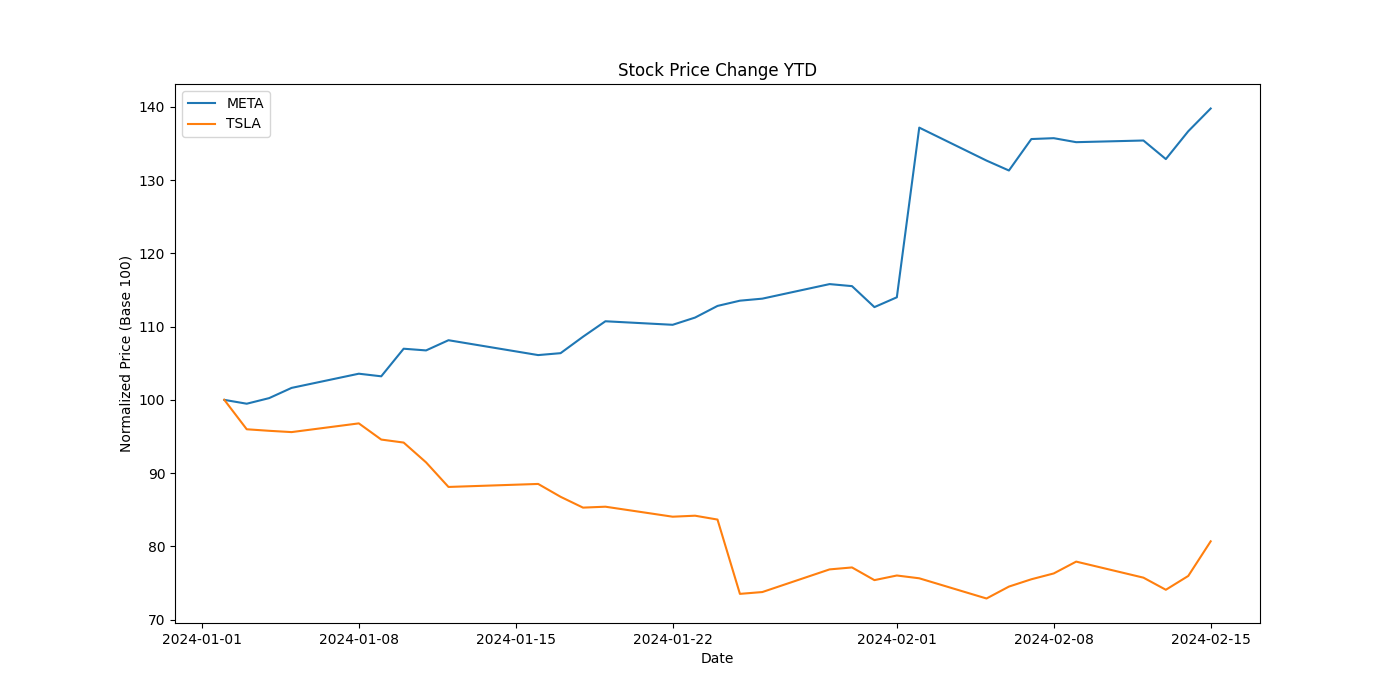

In [5]:
try:
    image = Image(filename="coding/stock_price_ytd.png")
    display(image)
except FileNotFoundError:
    print("Image not found. Please check the file name and modify if necessary.")

## Use a Different Code Execution Environment

The code execution happened in a separate process, so the plot is not directly displayed in the notebook. Is it possible to change the code execution environment into IPython?

Yes! In the following we demonstrate how to extend the `UserProxyAgent` to use a different code execution environment.

In [6]:
class IPythonUserProxyAgent(autogen.UserProxyAgent):
    def __init__(self, name: str, **kwargs):
        super().__init__(name, **kwargs)
        self._ipython = get_ipython()

    def generate_init_message(self, *args, **kwargs) -> Union[str, Dict]:
        return (
            super().generate_init_message(*args, **kwargs)
            + """
If you suggest code, the code will be executed in IPython."""
        )

    def run_code(self, code, **kwargs):
        result = self._ipython.run_cell("%%capture --no-display cap\n" + code)
        log = self._ipython.ev("cap.stdout")
        log += self._ipython.ev("cap.stderr")
        if result.result is not None:
            log += str(result.result)
        exitcode = 0 if result.success else 1
        if result.error_before_exec is not None:
            log += f"\n{result.error_before_exec}"
            exitcode = 1
        if result.error_in_exec is not None:
            log += f"\n{result.error_in_exec}"
            exitcode = 1
        return exitcode, log, None

The implementation overrides three functions in `UserProxyAgent`:
* constructor. We get the ipython instance as the code execution environment.
* `generate_init_message`. We generate a modified initial message to send to the assistant agent, by adding the info that the execution will be performed in IPython.
* `run_code`. We execute the code with the ipython instance.

With the new `IPythonUserProxyAgent`, we are able to run the code within the current notebook environment and display the plot directly.

ipython_user_proxy (to assistant):

Plot a chart of META and TESLA stock price gain YTD
If you suggest code, the code will be executed in IPython.

--------------------------------------------------------------------------------
self.reply_at_receive[sender]self.reply_at_receive[sender] True
recipitent sending assistant Plot a chart of META and TESLA stock price gain YTD
If you suggest code, the code will be executed in IPython. None
assistant (to ipython_user_proxy):

To plot a chart of META (Facebook's parent company, Meta Platforms, Inc.) and TESLA (Tesla, Inc.) stock price gain year-to-date (YTD), we can use Python with libraries such as `pandas` for data manipulation and `matplotlib` or `plotly` for plotting. We will also use `yfinance` to fetch historical stock data.

Here's the plan:
1. Install the `yfinance` library if it's not already installed.
2. Fetch the YTD stock price data for META and TESLA.
3. Calculate the YTD gain for each stock.
4. Plot the YTD gain on a chart.

Fir

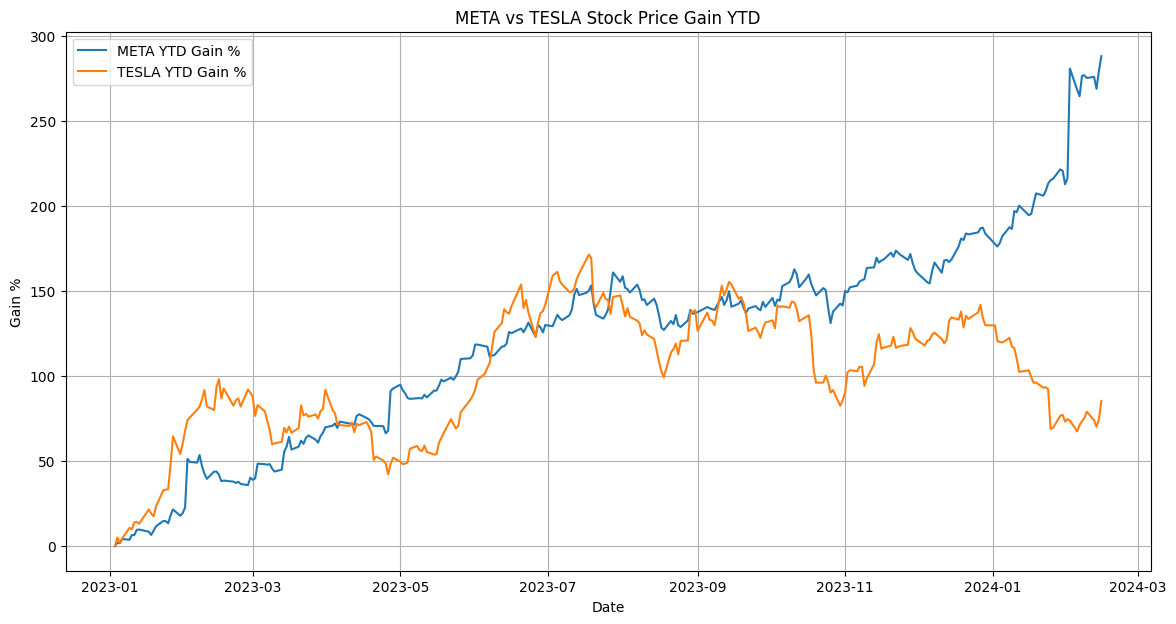

recipitent sending ipython_user_proxy To plot a chart of META (Facebook's parent company, Meta Platforms, Inc.) and TESLA (Tesla, Inc.) stock price gain year-to-date (YTD), we can use Python with libraries such as `pandas` for data manipulation and `matplotlib` or `plotly` for plotting. We will also use `yfinance` to fetch historical stock data.

Here's the plan:
1. Install the `yfinance` library if it's not already installed.
2. Fetch the YTD stock price data for META and TESLA.
3. Calculate the YTD gain for each stock.
4. Plot the YTD gain on a chart.

First, let's install `yfinance` and import the necessary libraries. Execute the following code:

```python
# Install yfinance if not already installed
!pip install yfinance

import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Check if today's date is required or the last trading day
today = datetime.today().strftime('%Y-%m-%d')

# Fetch YTD stock data for META and TESLA
meta_data =

ChatResult(chat_history=[{'content': 'Plot a chart of META and TESLA stock price gain YTD\nIf you suggest code, the code will be executed in IPython.', 'role': 'assistant'}, {'content': "To plot a chart of META (Facebook's parent company, Meta Platforms, Inc.) and TESLA (Tesla, Inc.) stock price gain year-to-date (YTD), we can use Python with libraries such as `pandas` for data manipulation and `matplotlib` or `plotly` for plotting. We will also use `yfinance` to fetch historical stock data.\n\nHere's the plan:\n1. Install the `yfinance` library if it's not already installed.\n2. Fetch the YTD stock price data for META and TESLA.\n3. Calculate the YTD gain for each stock.\n4. Plot the YTD gain on a chart.\n\nFirst, let's install `yfinance` and import the necessary libraries. Execute the following code:\n\n```python\n# Install yfinance if not already installed\n!pip install yfinance\n\nimport yfinance as yf\nimport pandas as pd\nimport matplotlib.pyplot as plt\nfrom datetime import date

In [7]:
ipy_user = IPythonUserProxyAgent(
    "ipython_user_proxy",
    human_input_mode="NEVER",
    max_consecutive_auto_reply=10,
    is_termination_msg=lambda x: x.get("content", "").rstrip().endswith("TERMINATE")
    or x.get("content", "").rstrip().endswith('"TERMINATE".'),
    code_execution_config={
        "use_docker": False,  # Please set use_docker=True if docker is available to run the generated code. Using docker is safer than running the generated code directly.
    },
)
# the assistant receives a message from the user, which contains the task description
ipy_user.initiate_chat(
    assistant,
    message="""Plot a chart of META and TESLA stock price gain YTD""",
)